In [148]:
%precision 3

import numpy as np
import pandas as pd
from pyinform import utils, transfer_entropy
from dtw import dtw as dynamic_time_warping
import pycwt as wavelet_coherence
from scipy.stats import gaussian_kde

from matplotlib import pyplot as plt
from matplotlib import ticker, collections, colors
plt.style.use("minimal")

In [149]:
SAMPLE_RATE = 300       # Hz (samples/second)
SPATIAL_SCALE = 1000    # spatial measurements were recorded in millimeters

In [150]:
class Session:
    def __init__(self, session_id):
        self.id = session_id

        datafile_path = f"data/Test{session_id}.tsv"

        metadata_header_lines = 9

        self.events = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = None, 
            names = ("Type", "Name", "Frame", "Time"), 
            skiprows=metadata_header_lines, 
            on_bad_lines = "skip"
        ).drop(columns = ["Type"])

        marker_names = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = None, 
            skiprows=metadata_header_lines + len(self.events), 
            nrows = 1
        ).loc[0, 1:].values

        self.markers = list(sorted(set([name[2:] for name in marker_names])))

        dataset = pd.read_csv(
            datafile_path, 
            sep = "\t", 
            header = metadata_header_lines + len(self.events) + 2, 
            usecols = lambda name: "Unnamed" not in name
        )

        dataset = dataset.set_index(["Frame", "Time"])
        dataset.columns = dataset.columns.str.split("_", expand = True)
        dataset = dataset.stack(0)
        dataset.columns = dataset.columns.str.split(" ", expand = True)
        dataset = dataset.stack(1)
        dataset.index = dataset.index.rename(["Frame", "Time", "Subject", "Axis"])
        dataset = dataset.reset_index()

        for frame, event_name in self.events.set_index("Frame")["Name"].items():
            dataset.loc[dataset["Frame"] == frame, "Event"] = event_name

        dataset.insert(2, "Trial", ((dataset["Event"] == "Trial") & (dataset["Event"].fillna(0) != dataset["Event"].fillna(0).shift())).cumsum() + 1)

        trials = []
        for trial, subset in dataset.groupby("Trial"):
            participants = []
            for subject, subset in subset.groupby("Subject"):
                marker_collection = []
                time_of_contact = self.events[self.events["Name"] == "Contact"]["Time"].iloc[trial - 1] - subset["Time"].min()
                subset["Frame"] -= subset["Frame"].min()
                subset["Time"] -= subset["Time"].min()
                for marker in self.markers:
                    pos_data = subset[["Frame", "Time", "Axis", marker]].pivot(index = ["Frame", "Time"], columns = ["Axis"], values = marker)
                    pos_data = pos_data[[dimension + "_Raw" for dimension in "XYZ"]] = pos_data.replace(0, np.nan)
                    pos_data[[dimension for dimension in "XYZ"]] = pos_data[[dimension for dimension in "XYZ"]].interpolate()
                    marker_collection.append(pos_data.reset_index())
                participants.append(pd.Series(marker_collection, name = "Marker", index = self.markers))
            trial_object = pd.Series(participants, name = "Participant", index = ["A", "B"])
            trial_object.time_of_contact = time_of_contact
            trials.append(trial_object)

        self.data = pd.Series(data = trials, index = np.arange(1, len(trials) + 1), name = "Trial")
    
    def __repr__(self):
        return f"[Session {self.id}]" + "\n" + f"Trial{'s' if len(self.data) > 1 else ''} {self.data.index[0]}{'-' + str(self.data.index[-1]) if len(self.data.index) > 1 else ''}" + "\n" + f"{len(self.markers)} markers ({', '.join(self.markers)})"

session = Session(session_id = 4)
print(session)

data = session.data

[Session 4]
Trials 1-4
8 markers (Biceps, Elbow, Hand, HipLeft, HipRight, ShoulderLeft, ShoulderRight, Wrist)


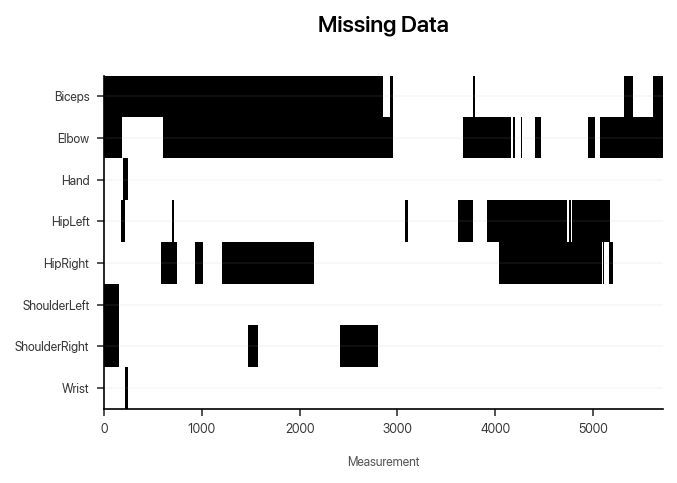

In [151]:
def assess_missing(trial, markers = None):
    a = []
    markers = markers if markers else session.markers
    for marker in markers:
        subset = pd.concat([data[trial]["A"][marker], data[trial]["B"][marker]])
        a.append(subset.isna().any(axis = 1))
    plt.imshow(np.where(np.array(a).astype(int) > 0.5, 1, 0.15), interpolation = "none", aspect = "auto", cmap = "binary")
    plt.yticks(range(len(markers)), markers)
    plt.xlabel("Measurement")
    plt.title("Missing Data\n")
    plt.tight_layout()

assess_missing(trial = 3)

In [152]:
def mark_point_of_contact(trial):
    plt.axvline(data[trial].time_of_contact, color = "black", linestyle = "--", alpha = 0.1, zorder = -1)

def annotate_metadata(trial, marker, axis = None):
    plt.figtext(0.9, 0.9, f"Trial {trial}\n{marker}" + f" {axis if axis else ''}", ha = "center")

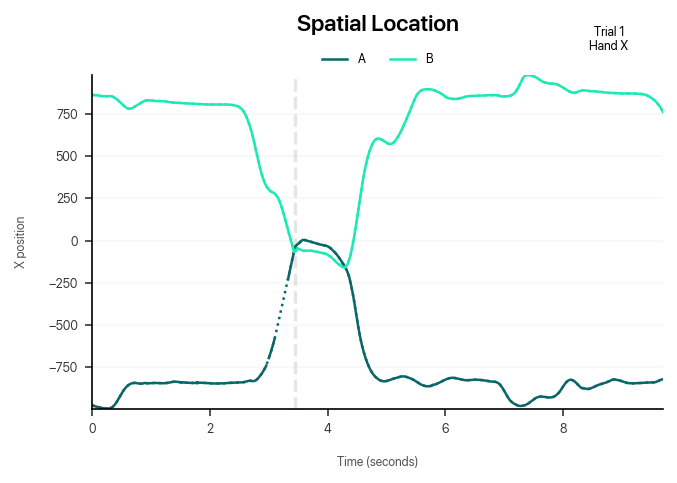

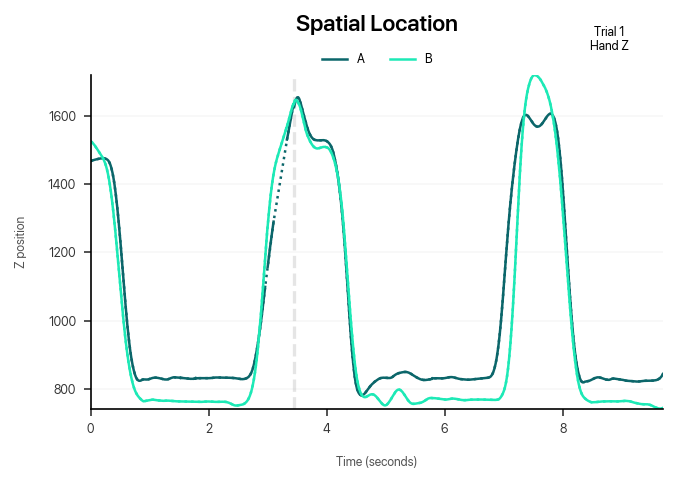

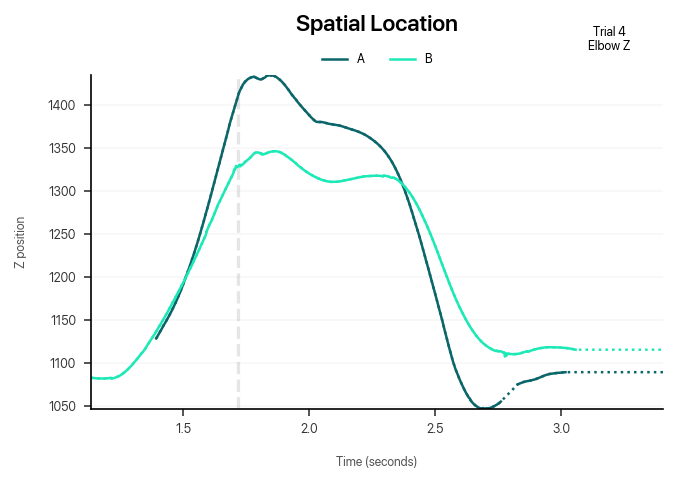

In [153]:
def plot_position(trial, marker, axis):
    plt.figure()
    mark_point_of_contact(trial)
    for subject, subset in data[trial].items():
        plt.plot(
            subset[marker]["Time"], 
            subset[marker][axis + "_Raw"],
            linewidth = 1.2, 
            label = subject, 
            color = dict(A = "C0", B = "C1")[subject]
        )
        plt.plot(
            subset[marker]["Time"], 
            subset[marker][axis], 
            linewidth = 1.2, 
            linestyle = ":", 
            color = dict(A = "C0", B = "C1")[subject]
        )
    plt.margins(x = 0, y = 0)
    plt.title("Spatial Location\n")
    annotate_metadata(trial, marker, axis)
    plt.xlabel("Time (seconds)")
    plt.ylabel(f"{axis} position")
    plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.1), ncol = 2)
    plt.tight_layout()

plot_position(trial = 1, marker = "Hand", axis = "X")
plot_position(trial = 1, marker = "Hand", axis = "Z")
plot_position(trial = 4, marker = "Elbow", axis = "Z")

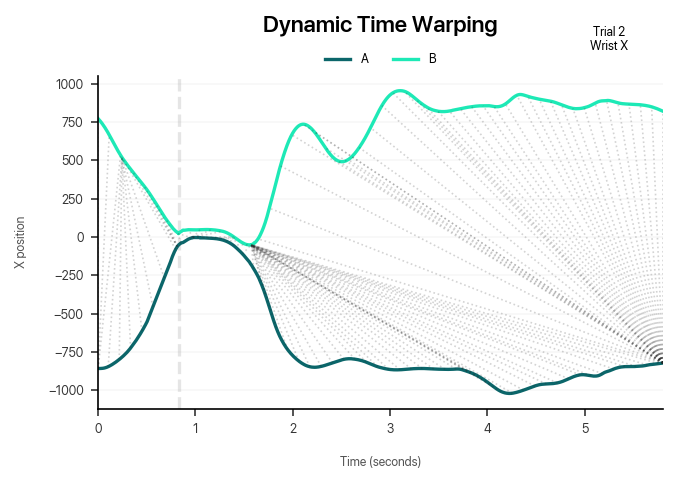

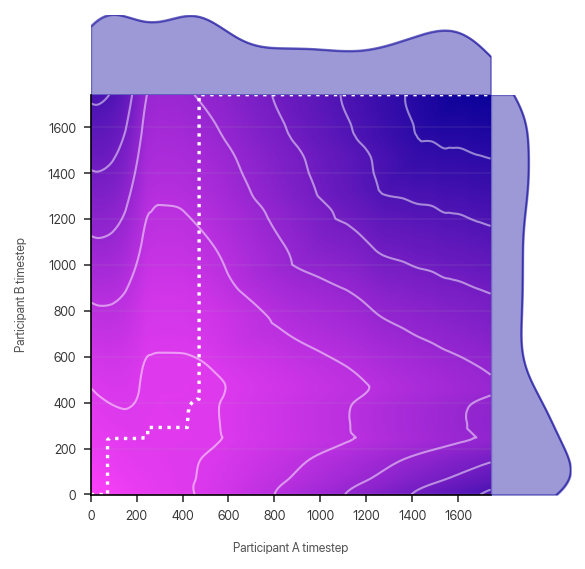

In [154]:
def plot_dynamic_time_warping(trial, marker, axis):
    reference = data[trial]["A"][marker][axis]
    query = data[trial]["B"][marker][axis]
    time_sequence = data[trial]["A"][marker]["Time"]

    d = dynamic_time_warping(reference, query, keep_internals=True)

    cmap = colors.LinearSegmentedColormap.from_list("deep", ["#FF42FB", "#0B0299"], N = 256)

    plt.figure()
    plt.title("Dynamic Time Warping\n")
    annotate_metadata(trial, marker, axis)

    mark_point_of_contact(trial)

    plt.plot(time_sequence, reference, label = "A")
    plt.plot(time_sequence, query, label = "B")

    plt.xlabel("Time (seconds)")
    plt.ylabel(f"{axis} position")

    col = []
    for i in np.linspace(0, len(d.index1) - 1, num = 100).astype(int):
        col.append([
            (time_sequence.min() + d.index1[i] / SAMPLE_RATE, reference[d.index1[i]]),
            (time_sequence.min() + d.index2[i] / SAMPLE_RATE, query[d.index2[i]])
        ]) 
    plt.gca().add_collection(collections.LineCollection(col, linestyles=":", linewidths = 0.8, colors = (0.15, 0.15, 0.15), alpha = 0.2))
    plt.margins(x = 0, y = 0.05)
    plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.1), ncol = 2)

    plt.tight_layout()

    fig, axes = plt.subplots(
        figsize=(3.2, 3.2), 
        nrows = 2, 
        ncols = 2, 
        width_ratios = (5, 1), 
        height_ratios = (1, 5), 
        gridspec_kw=dict(
            left = 0, 
            right = 1, 
            bottom = 0, 
            top = 1, 
            hspace = 0, 
            wspace = 0
        )
    )

    ax_empty = axes[0][1]
    ax_x_dist = axes[0][0]
    ax_y_dist = axes[1][1]
    ax_scatter = axes[1][0]

    for ax in (ax_empty, ax_x_dist, ax_y_dist):
        ax.axis("off")
        ax.margins(x = 0, y = 0)

    ax_scatter.imshow(d.costMatrix.T, origin="lower", cmap = cmap, interpolation = "none", aspect = 1)
    ax_scatter.contour(d.costMatrix.T, colors = "white", linewidths = 1, alpha = 0.5)
    ax_scatter.plot(
        d.index2, 
        d.index1, 
        color="white", 
        linestyle = ":"
    )
    ax_scatter.set_xlabel("Participant A timestep")
    ax_scatter.set_ylabel("Participant B timestep")

    for dist, ax, orientation in zip((d.costMatrix.T.mean(axis = 0), d.costMatrix.T.mean(axis = 1)), (ax_x_dist, ax_y_dist), ("", "rotated")):
        density_kernel = gaussian_kde(dist)
        data_range = np.arange(dist.min(), dist.max(), 100)
        density_data = data_range, density_kernel(data_range)
        if orientation:
            ax.plot(*density_data[::-1], alpha = 0.5, zorder = -1, lw = 1, color = "#0B0299")
            ax.fill_betweenx(*density_data, alpha = 0.4, interpolate=True, color = "#0B0299")
        else:
            ax.plot(*density_data, alpha = 0.5, zorder = -1, lw = 1, color = "#0B0299")
            ax.fill_between(*density_data, alpha = 0.4, interpolate=True, color = "#0B0299")

    plt.show()

# plot_dynamic_time_warping(trial = 2, marker = "Hand", axis = "X")
plot_dynamic_time_warping(trial = 2, marker = "Wrist", axis = "X")
# plot_dynamic_time_warping(trial = 2, marker = "Elbow", axis = "Z")

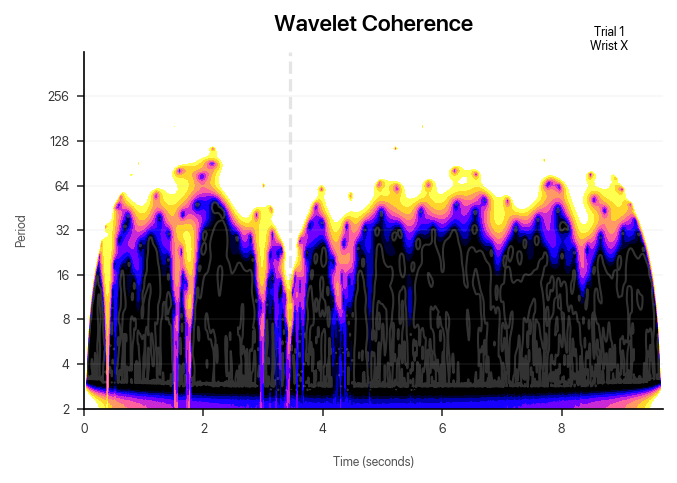

In [155]:
# https://pycwt.readthedocs.io/en/latest/tutorial.html#references
# https://github.com/regeirk/pycwt/blob/main/pycwt/wavelet.py

def plot_wavelet_coherence(trial, marker, axis):
    signal_data = data[trial]["A"][marker][axis] - data[trial]["B"][marker][axis]

    wave, scales, freqs, coi, fft, fftfreqs = wavelet_coherence.cwt(signal_data.values, dt = 1)

    power = np.abs(wave) ** 2
    fft_power = np.abs(fft) ** 2
    period = 1 / freqs
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32]

    extent = [signal_data.index.min(), signal_data.index.max(), 0, max(period)]

    signif, fft_theor = wavelet_coherence.significance(
        1, 
        dt = 1, 
        scales = scales, 
        sigma_test = 0, 
        alpha = wavelet_coherence.ar1(signal_data.values)[0],
        significance_level=0.95,
        wavelet=wavelet_coherence.Morlet(8)
    )

    plt.figure()

    mark_point_of_contact(trial)

    plt.contourf(
        data[trial]["A"][marker]["Time"], 
        np.log2(period), 
        np.log2(power), 
        np.log2(levels), 
        cmap="gnuplot2",
        extend="both", 
        zorder = -2
    )
    plt.contour(
        data[trial]["A"][marker]["Time"], 
        np.log2(period), 
        power / signif.reshape(-1, 1), 
        [0.95], 
        colors="white", 
        linewidths=1, 
        alpha = 0.2, 
        extent=extent, 
        zorder = -2
    )

    plt.title("Wavelet Coherence")
    annotate_metadata(trial, marker, axis)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Period")
    ylim_min, ylim_max = (period.min(), 512)
    y_ticks = 2 ** np.arange(np.floor(np.log2(ylim_min)), np.ceil(np.log2(ylim_max)))
    # plt.yscale("log", base = 2)
    plt.ylim(np.log2([ylim_min, ylim_max]))
    plt.yticks(np.log2(y_ticks), y_ticks.astype(int))

    plt.tight_layout()

plot_wavelet_coherence(1, "Wrist", "X")

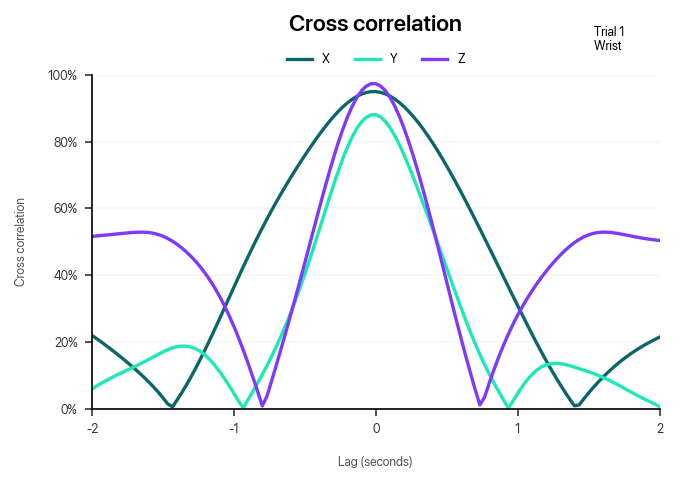

In [156]:
def plot_cross_correlation(trial, marker, lags = np.arange(-600, 600 + 1, 10)):
    plt.figure()
    for axis in "XYZ":
        cross_corrs = [abs(data[trial]["A"][marker][axis].corr(data[trial]["B"][marker][axis].shift(lag))) for lag in lags]
        plt.plot(lags, cross_corrs, label = f"{axis}")
    plt.title("Cross correlation\n")
    annotate_metadata(trial, marker)
    plt.xlabel("Lag (seconds)")
    plt.ylabel("Cross correlation")
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(300))
    plt.gca().xaxis.set_major_formatter(lambda val, idx: round(val / 300))
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.margins(x = 0, y = 0.1)
    plt.ylim((0, 1))
    plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.1), ncol = 3)
    plt.tight_layout()

plot_cross_correlation(trial = 1, marker = "Wrist")

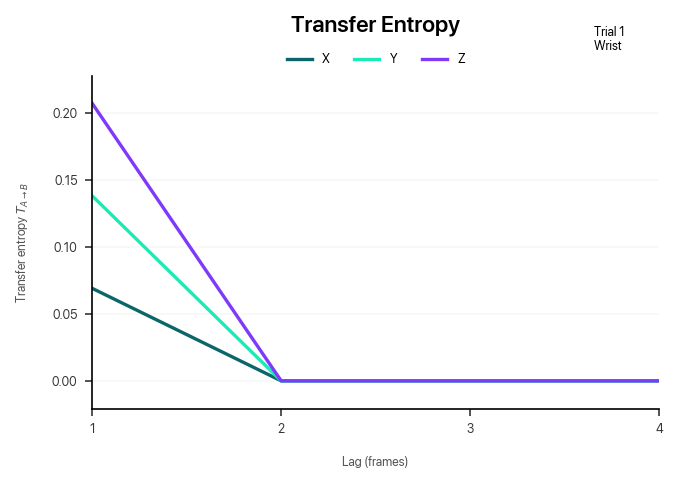

In [157]:
def plot_transfer_entropy(trial, marker, lags = np.arange(1, 5)):
    plt.figure()
    for axis in "XYZ":
        downsample_scale = 100
        plt.plot(lags, [transfer_entropy(utils.coalesce_series(data[trial]["A"][marker][axis][::downsample_scale])[0], utils.coalesce_series(data[trial]["B"][marker][axis][::downsample_scale])[0], k = lag) for lag in lags], label = f"{axis}")
    plt.title("Transfer Entropy\n")
    annotate_metadata(trial, marker)
    plt.xlabel("Lag (frames)")
    plt.ylabel(r"Transfer entropy $T_{A \rightarrow B}$")
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.margins(x = 0, y = 0.1)
    plt.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.1), ncol = 3)
    plt.tight_layout()

plot_transfer_entropy(trial = 1, marker = "Wrist")

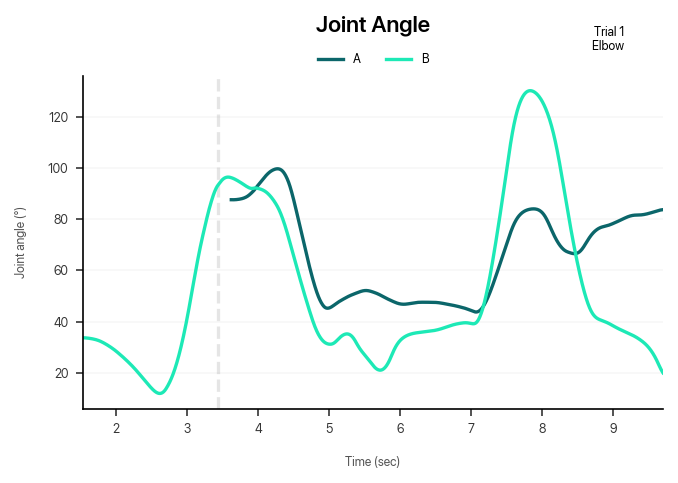

In [158]:
def calc_angle(datasets):
    diff1 = datasets[0] - datasets[1]
    line1 = (diff1).divide(np.linalg.norm(diff1.values, axis = 1), axis = 0)
    diff2 = datasets[1] - datasets[2]
    line2 = (diff2).divide(np.linalg.norm(diff2.values, axis = 1), axis = 0)

    return pd.Series(np.degrees(np.arccos(np.clip(np.sum(line1.values * line2.values, axis = 1), -1, 1)))).rolling(int(SAMPLE_RATE / 2)).mean()

def plot_angles(trial, markers):
    markers = list(markers)
    mark_point_of_contact(trial)
    for participant in "AB":
        datasets = [data[trial][participant][marker][["X", "Y", "Z"]] for marker in markers]
        plt.plot(data[trial][participant][markers[0]]["Time"], calc_angle(datasets), label = participant)
    plt.title("Joint Angle\n")
    annotate_metadata(trial, markers[1])
    plt.xlabel("Time (sec)")
    plt.ylabel("Joint angle (°)")
    plt.margins(x=0)
    plt.legend(loc = "upper center", bbox_to_anchor=(0.5, 1.1), ncol = 2)
    plt.tight_layout()

plot_angles(trial = 1, markers = ("ShoulderRight", "Elbow", "Wrist"))

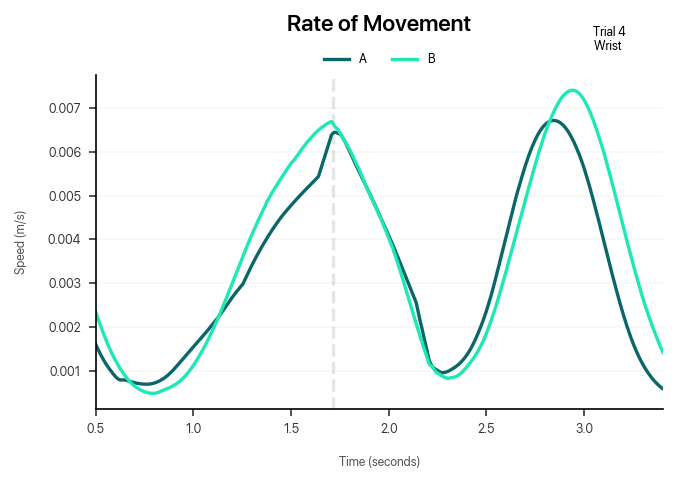

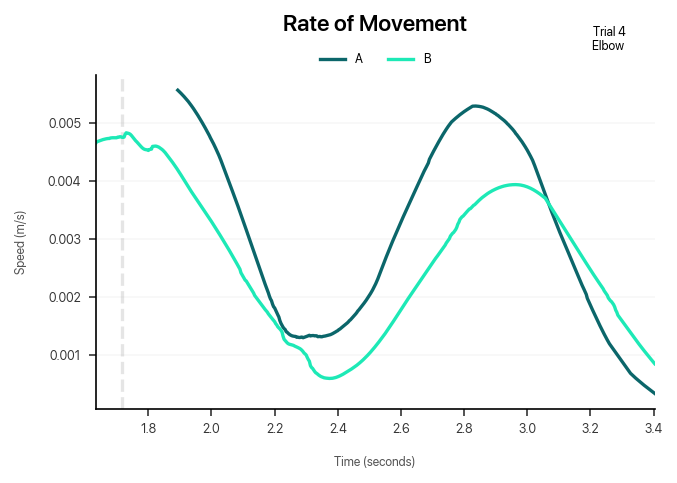

In [159]:
def calculate_velocity(subset):
    delta_pos = subset[["X", "Y", "Z"]].values - subset[["X", "Y", "Z"]].shift(1).values
    subset["v"] = np.sqrt(np.sum(delta_pos ** 2, axis = 1))
    subset["v"] = subset["v"].iloc[1:].rolling(int(SAMPLE_RATE / 2)).mean() / SPATIAL_SCALE # rescale from ms/s to m/s
    return subset["v"]

def plot_velocity(trial, marker):
    plt.figure()
    mark_point_of_contact(trial)
    for participant in "AB":
        plt.plot(data[trial][participant][marker]["Time"], calculate_velocity(data[trial][participant][marker]), label = participant)
    plt.title("Rate of Movement\n")
    annotate_metadata(trial, marker)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Speed (m/s)")
    plt.margins(x=0)
    plt.legend(loc = "upper center", bbox_to_anchor=(0.5, 1.1), ncol = 2)
    plt.tight_layout()

plot_velocity(trial = 4, marker = "Wrist")
plot_velocity(trial = 4, marker = "Elbow")